In [1]:
# default
import time
import os
import glob
import uuid
import concurrent
import concurrent.futures
import requests
import json
import datetime
import soundfile as sf
import io
# optional
from pathlib import Path
import numpy as np
import torch
from einops import repeat
from torch import Tensor
from torch.nn import functional as F
from transformers import AutoTokenizer
from vocos import get_voco
from model.module_voice import AudioBoxModule
from torchode.interface import solve_ivp
import torchaudio
import librosa

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# model functions
class Infer:
    def __init__(self, path: Path):
        self.device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )
        self.model = AudioBoxModule.load_from_checkpoint(path).to(self.device)
        self.model.eval()
        self.voco = get_voco(self.model.voco_type).to(self.device)

        self.tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
        self.tokenizer.padding_side = "right"

        self.steps = 64
        self.alpha = 3.0

    @torch.no_grad()
    @torch.autocast(device_type="cuda", enabled=False)
    def encode_text(self, texts: list[str]) -> tuple[Tensor, Tensor]:
        batch_encoding = self.tokenizer(
            [text + self.tokenizer.eos_token for text in texts],
            add_special_tokens=False,
            return_tensors="pt",
            max_length=127,
            truncation="longest_first",
            padding="max_length",
        )
        phoneme = batch_encoding.input_ids.to(self.device)
        phoneme_mask = batch_encoding.attention_mask.to(self.device) > 0
        phoneme_emb = self.model.t5(
            input_ids=phoneme, attention_mask=phoneme_mask
        ).last_hidden_state

        return phoneme_emb, phoneme_mask

    @torch.no_grad()
    @torch.autocast(device_type="cuda")
    def generate(
        self, texts: list[str], dur: float, cfg=3.0, voice_enc: Tensor =None
    ) -> list[np.ndarray]:
        phoneme_emb, phoneme_mask = self.encode_text(texts)
        batch_size = phoneme_emb.shape[0]

        target_len = round(self.model.sampling_rate * dur)
        latent_len = self.voco.encode_length(target_len)
        audio_mask = torch.ones(
            batch_size, latent_len, dtype=torch.bool, device=self.device
        )
        audio_context = torch.zeros(
            batch_size, latent_len, self.voco.latent_dim, device=self.device
        )

        if latent_len < 192:
            audio_mask = F.pad(audio_mask, (0, 192 - latent_len))
            audio_context = F.pad(audio_context, (0, 0, 0, 192 - latent_len))
            voice_enc = F.pad(voice_enc, (0, 0, 0, 192 - voice_enc.shape[1]))
        elif 192 < latent_len < 384:
            audio_mask = F.pad(audio_mask, (0, 384 - latent_len))
            audio_context = F.pad(audio_context, (0, 0, 0, 384 - latent_len))
            voice_enc = F.pad(voice_enc, (0, 0, 0, 384 - voice_enc.shape[1]))
        elif 384 < latent_len < 768:
            audio_mask = F.pad(audio_mask, (0, 768 - latent_len))
            audio_context = F.pad(audio_context, (0, 0, 0, 768 - latent_len))
            voice_enc = F.pad(voice_enc, (0, 0, 0, 768 - voice_enc.shape[1]))
        elif 768 < latent_len < 1536:
            audio_mask = F.pad(audio_mask, (0, 1536 - latent_len))
            audio_context = F.pad(audio_context, (0, 0, 0, 1536 - latent_len))
            voice_enc = F.pad(voice_enc, (0, 0, 0, 1536 - voice_enc.shape[1]))

        if voice_enc is None:
            voice_enc = torch.zeros((audio_context.shape[0], audio_context.shape[1], 12), device=audio_context.device)

        def fn(t: Tensor, y: Tensor):
            out = self.model.audiobox.cfg(
                w=y,
                context=audio_context,
                times=t,
                alpha=cfg,
                mask=audio_mask,
                phoneme_emb=phoneme_emb,
                phoneme_mask=phoneme_mask,
                voice_enc=voice_enc
            )
            return out

        y0 = torch.randn_like(audio_context)
        t = torch.linspace(0, 1, self.steps, device=self.device)

        t = repeat(t, "n -> b n", b=batch_size)
        sol = solve_ivp(
            fn,
            # torch.compile(fn, dynamic=False),
            y0,
            t,
            method_class=self.model.method, #self.model.torchode_method_klass,
        )
        sampled_audio = sol.ys[-1]

        sample = self.voco.decode(sampled_audio)
        sample = sample[:, :target_len]

        sample = sample / sample.abs().amax(dim=1, keepdim=True).clamp_min(1)
        sample = sample.detach().cpu().float().numpy().astype(np.float32)

        return [audio for audio in sample]

    @torch.no_grad()
    @torch.autocast(device_type="cuda")
    def variation(
        self, audios: list[np.ndarray], texts: list[str], dur: float, corrupt: float, sr: list[int], cfg_score: int = 3.0, voice_enc: Tensor=None
    ) -> list[np.ndarray]:
        phoneme_emb, phoneme_mask = self.encode_text(texts)
        batch_size = phoneme_emb.shape[0]

        audios = [audio / np.iinfo(audio.dtype).max for audio in audios]
        audio_tensor = torch.from_numpy(np.stack(audios, axis=0)).to(self.device)
        audio_tensor = audio_tensor.float()
        ##
        audio_tensor = audio_tensor.transpose(1, 2)
        audio_tensor = torchaudio.functional.resample(audio_tensor, orig_freq=sr[0], new_freq=self.voco.sampling_rate)
        audio_tensor = audio_tensor.transpose(1, 2)
        if audio_tensor.shape[2] == 1:
            audio_tensor = audio_tensor.repeat(1, 1, 2)
        elif audio_tensor.shape[2] > 2:
            audio_tensor = audio_tensor[:, :, :2]
        target_len = audio_tensor.shape[1]
        latent_len = self.voco.encode_length(target_len)
        audio_enc = self.voco.encode(audio_tensor)
        audio_mask = torch.ones(
            batch_size, latent_len, dtype=torch.bool, device=self.device
        )
        audio_context = torch.zeros(
            batch_size, latent_len, self.voco.latent_dim, device=self.device
        )

        if latent_len < 192:
            audio_enc = F.pad(audio_enc, (0, 0, 0, 192 - latent_len))
            audio_mask = F.pad(audio_mask, (0, 192 - latent_len))
            audio_context = F.pad(audio_context, (0, 0, 0, 192 - latent_len))
            voice_enc = F.pad(voice_enc, (0, 0, 0, 192 - voice_enc.shape[1]))
        elif 192 < latent_len < 384:
            audio_enc = F.pad(audio_enc, (0, 0, 0, 384 - latent_len))
            audio_mask = F.pad(audio_mask, (0, 384 - latent_len))
            audio_context = F.pad(audio_context, (0, 0, 0, 384 - latent_len))
            voice_enc = F.pad(voice_enc, (0, 0, 0, 384 - voice_enc.shape[1]))
        elif 384 < latent_len < 768:
            audio_enc = F.pad(audio_enc, (0, 0, 0, 768 - latent_len))
            audio_mask = F.pad(audio_mask, (0, 768 - latent_len))
            audio_context = F.pad(audio_context, (0, 0, 0, 768 - latent_len))
            voice_enc = F.pad(voice_enc, (0, 0, 0, 768 - voice_enc.shape[1]))
        elif 768 < latent_len < 1536:
            audio_enc = F.pad(audio_enc, (0, 0, 0, 1536 - latent_len))
            audio_mask = F.pad(audio_mask, (0, 1536 - latent_len))
            audio_context = F.pad(audio_context, (0, 0, 0, 1536 - latent_len))
            voice_enc = F.pad(voice_enc, (0, 0, 0, 1536 - voice_enc.shape[1]))

        sigma = 1e-3
        c = 1.0 - corrupt
        noised_enc = (audio_enc * c) + torch.randn_like(audio_enc) * (1 - (1 - sigma) * c)
        corrupt_tensor = torch.tensor(1 - corrupt).to(self.device)
        # print("corrupt_tensor : ", corrupt_tensor)

        def forward(t: Tensor, y: Tensor):
            # print("times : ", t)
            out = self.model.audiobox.cfg(
                w=y,
                context=audio_context,
                # times=t,
                times=t,
                alpha=cfg_score,
                mask=audio_mask,
                phoneme_emb=phoneme_emb,
                phoneme_mask=phoneme_mask,
                voice_enc=voice_enc
            )
            return out

        # t = torch.linspace(c, 1, 64, device=self.device)
        t = torch.linspace(0, corrupt, self.steps, device=self.device)

        t = repeat(t, "n -> b n", b=batch_size)
        sol = solve_ivp(
            # torch.compile(forward, dynamic=False),
            forward,
            noised_enc,
            t+corrupt_tensor, # 0.6 ~ 1.0
            method_class=self.model.method #.torchode_method_klass,
        )
        sampled_audio = sol.ys[-1]

        sample = self.voco.decode(sampled_audio)
        new_target_len = round(self.model.sampling_rate * dur)
        sample = sample[:, :new_target_len]

        sample = sample / sample.abs().amax(dim=1, keepdim=True).clamp_min(1)
        sample = sample.detach().cpu().numpy().astype(np.float32)

        return [audio for audio in sample]

def convert_to_int16(audio_array):
    """
    오디오 배열을 int16 형식으로 변환.
    """
    # float형 오디오 배열을 int16 범위로 스케일링
    audio_array = np.clip(audio_array, -1.0, 1.0)  # -1.0 ~ 1.0 범위로 제한
    audio_int16 = (audio_array * 32767).astype(np.int16)
    return audio_int16

In [3]:
# prepare model
infer = Infer(Path("./dynamic_v3_0415.ckpt"))

voco type  :  oobleck


In [4]:
from einops import rearrange
from audiotools import AudioSignal
import time
import torchaudio
from utils.utils import get_dynamic
import torch
import random

def span_mask(tensor, mask_frac=0.3, min_len=4, max_len=10):
    B, T, D = tensor.shape
    assert B == 1, "이 코드는 배치 크기 1 기준입니다."

    total_mask_len = int(T * mask_frac)
    mask = torch.zeros(T, dtype=torch.bool)

    masked = 0
    while masked < total_mask_len:
        span_len = random.randint(min_len, max_len)
        if masked + span_len > total_mask_len:
            span_len = total_mask_len - masked

        start = random.randint(0, T - span_len)
        mask[start : start + span_len] = True
        masked += span_len

    # [1, 100, 12] shape에 맞게 broadcast
    mask = mask[None, :, None].expand(B, T, D)  # [1, 100, 12]

    # 마스킹 적용
    masked_tensor = tensor.masked_fill(mask, 0.0)
    return masked_tensor

def span_mask_strided(tensor, span_len=6, stride=16):
    """
    일정한 간격(stride)마다 일정 길이(span_len)로 마스크를 적용하는 함수

    Args:
        tensor (Tensor): 입력 텐서, shape (1, T, D)
        span_len (int): 마스크될 구간 길이
        stride (int): 마스크가 시작되는 위치 간격

    Returns:
        masked_tensor: 마스킹이 적용된 텐서
    """
    B, T, D = tensor.shape
    assert B == 1, "이 코드는 배치 크기 1 기준입니다."

    mask = torch.zeros(T, dtype=torch.bool)
    for start in range(0, T, stride):
        end = min(start + span_len, T)
        mask[start:end] = True

    # [1, T, D]로 broadcast
    mask = mask[None, :, None].expand(B, T, D)
    masked_tensor = tensor.masked_fill(mask, 0.0)
    return masked_tensor

import matplotlib.pyplot as plt

In [ ]:
audiofile = "./voice_samples/blood.mp3"
duration = 5.5
prompt =  "blood, gore, blood emitting from body." # "Sound of coin dropping on iron surface."
save_word = "tiriring"

sampling_rate = 44100
waveform, sr = torchaudio.load(audiofile)
if sr != sampling_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sampling_rate)
waveform = waveform.mean(dim=0, keepdim=True)[:, int(44100*0.0):int(44100*duration)]

dynamic = get_dynamic(waveform, max_len=110)
voice_enc=dynamic.unsqueeze(dim=0)
voice_enc_masked = span_mask_strided(voice_enc, 1, 2)

AudioSignal(audiofile, sample_rate=44100).widget()

for i in range(3):
    output_audios = infer.generate([
        prompt,
    ]*1, duration, 3.0, voice_enc=voice_enc.to('cuda'))
    for aa in output_audios:
        aa = rearrange(aa, 's t -> t s')
        AudioSignal(aa, sample_rate=44100).widget()


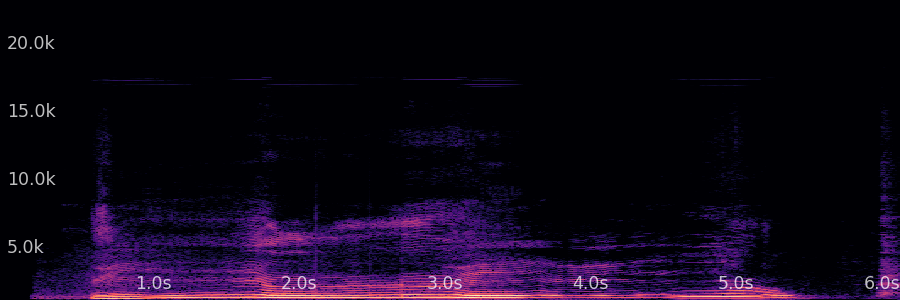
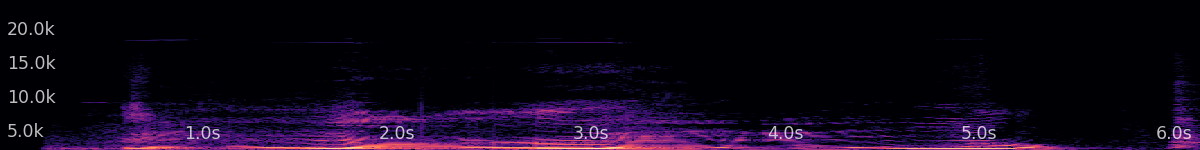

Solving ODE...:  98%|█████████▊| 63/64 [00:03<00:00, 17.01it/s]



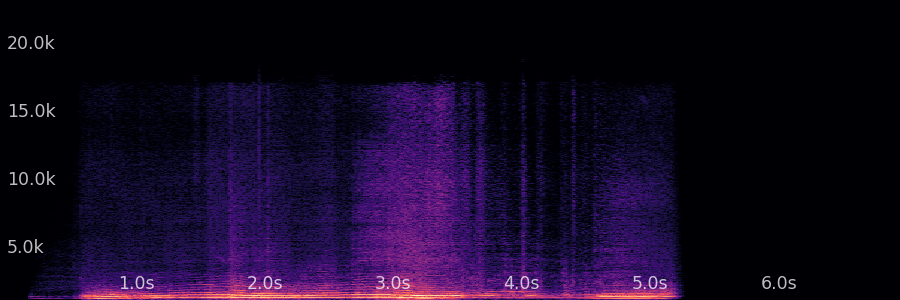
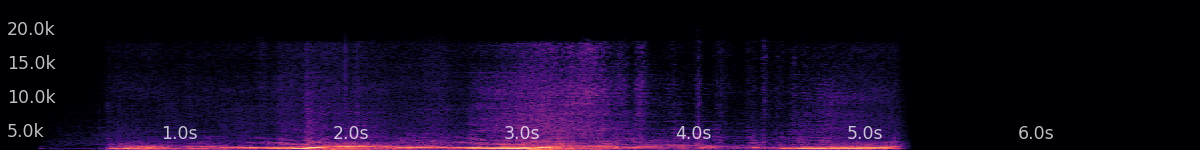

Solving ODE...:  98%|█████████▊| 63/64 [00:03<00:00, 18.74it/s]



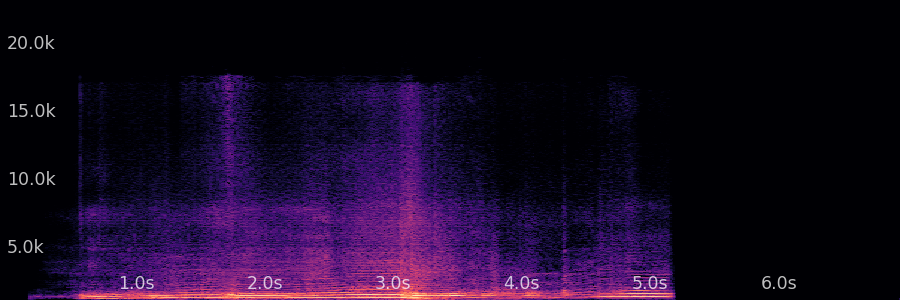
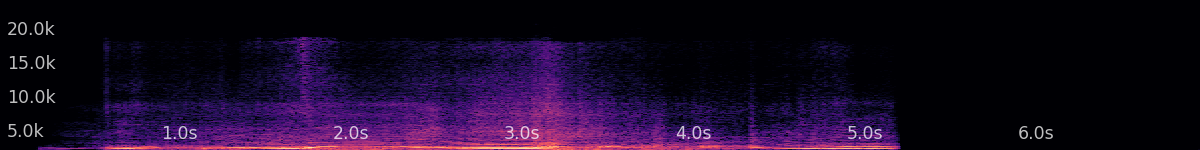

Solving ODE...:  98%|█████████▊| 63/64 [00:03<00:00, 18.72it/s]


In [ ]:
audiofile = "./voice_samples/voice_drive.mp3"
duration = 7
prompt =  "motor cycle driving fastly on the road." # "Sound of coin dropping on iron surface."
save_word = "tiriring"

sampling_rate = 44100
waveform, sr = torchaudio.load(audiofile)
if sr != sampling_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sampling_rate)
waveform = waveform.mean(dim=0, keepdim=True)[:, int(44100*0.0):int(44100*duration)]

dynamic = get_dynamic(waveform, max_len=110)
voice_enc=dynamic.unsqueeze(dim=0)
voice_enc_masked = span_mask_strided(voice_enc, 1, 2)

AudioSignal(audiofile, sample_rate=44100).widget()

for i in range(3):
    output_audios = infer.generate([
        prompt,
    ]*1, duration, 3.0, voice_enc=voice_enc.to('cuda'))
    for aa in output_audios:
        aa = rearrange(aa, 's t -> t s')
        AudioSignal(aa, sample_rate=44100).widget()

In [ ]:
audiofile = "./voice_samples/monster.mp3"
duration = 7
prompt =  "sound of monster growling. & low pitch range" # "Sound of coin dropping on iron surface."
save_word = "tiriring"

sampling_rate = 44100
waveform, sr = torchaudio.load(audiofile)
if sr != sampling_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sampling_rate)
waveform = waveform.mean(dim=0, keepdim=True)[:, int(44100*0.0):int(44100*duration)]

dynamic = get_dynamic(waveform, max_len=110)
voice_enc=dynamic.unsqueeze(dim=0)
# voice_enc_masked = span_mask_strided(voice_enc, 1, 2)

AudioSignal(audiofile, sample_rate=44100).widget()

for i in range(3):
    output_audios = infer.generate([
        prompt,
    ]*1, duration, 3.0, voice_enc=voice_enc.to('cuda'))
    for aa in output_audios:
        aa = rearrange(aa, 's t -> t s')
        AudioSignal(aa, sample_rate=44100).widget()

In [ ]:
audiofile = "./voice_samples/whichik.mp3"
duration = 4.5
prompt =  "whipping sound." # "Sound of coin dropping on iron surface."
save_word = "tiriring"

sampling_rate = 44100
waveform, sr = torchaudio.load(audiofile)
if sr != sampling_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sampling_rate)
waveform = waveform.mean(dim=0, keepdim=True)[:, int(44100*0.0):int(44100*duration)]

dynamic = get_dynamic(waveform, max_len=110)
voice_enc=dynamic.unsqueeze(dim=0)
# voice_enc_masked = span_mask_strided(voice_enc, 1, 2)

AudioSignal(audiofile, sample_rate=44100).widget()

for i in range(3):
    output_audios = infer.generate([
        prompt,
    ]*1, duration, 3.0, voice_enc=voice_enc.to('cuda'))
    for aa in output_audios:
        aa = rearrange(aa, 's t -> t s')
        AudioSignal(aa, sample_rate=44100).widget()

In [ ]:
audiofile = "./voice_samples/monsterroar.mp3"
duration = 6.0
prompt =  "monster roaring. & rich pitch sound" # "Sound of coin dropping on iron surface."
save_word = "tiriring"

sampling_rate = 44100
waveform, sr = torchaudio.load(audiofile)
if sr != sampling_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sampling_rate)
waveform = waveform.mean(dim=0, keepdim=True)[:, int(44100*0.0):int(44100*duration)]

dynamic = get_dynamic(waveform, max_len=110)
voice_enc=dynamic.unsqueeze(dim=0)
voice_enc_masked = span_mask_strided(voice_enc, 1, 2)

AudioSignal(audiofile, sample_rate=44100).widget()

for i in range(3):
    output_audios = infer.generate([
        prompt,
    ]*1, duration, 3.0, voice_enc=voice_enc.to('cuda'))
    for aa in output_audios:
        aa = rearrange(aa, 's t -> t s')
        AudioSignal(aa, sample_rate=44100).widget()

In [ ]:
audiofile = "./voice_samples/ironchain.mp3"
duration = 6.5
prompt =  "clinking of chains." # "Sound of coin dropping on iron surface."
save_word = "tiriring"

sampling_rate = 44100
waveform, sr = torchaudio.load(audiofile)
if sr != sampling_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sampling_rate)
waveform = waveform.mean(dim=0, keepdim=True)[:, int(44100*0.0):int(44100*duration)]

dynamic = get_dynamic(waveform, max_len=110)
voice_enc=dynamic.unsqueeze(dim=0)
# voice_enc_masked = span_mask_strided(voice_enc, 1, 2)

AudioSignal(audiofile, sample_rate=44100).widget()

for i in range(3):
    output_audios = infer.generate([
        prompt,
    ]*1, duration, 3.0, voice_enc=voice_enc.to('cuda'))
    for aa in output_audios:
        aa = rearrange(aa, 's t -> t s')
        AudioSignal(aa, sample_rate=44100).widget()

In [ ]:
audiofile = './voice_samples/charging.m4a'
sampling_rate = 44100

waveform, sr = torchaudio.load(audiofile)
if sr != sampling_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sampling_rate)
waveform = waveform.mean(dim=0, keepdim=True)[:, :int(44100*5)]

dynamic = get_dynamic(waveform, max_len=110)

print(waveform.shape)
print(dynamic.shape)

voice_enc=dynamic.unsqueeze(dim=0)

# voice_enc_masked = span_mask(voice_enc, 0.0, 4, 10)
# visualize_mask(voice_enc, voice_enc_masked)

voice_enc_masked = span_mask_strided(voice_enc, 1, 2)
# voice_enc_masked[:, :, :4] = 0.0

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# 시각화할 feature index들
feature_indices = [0, 4, 8]

# Plot
for i, idx in enumerate(feature_indices):
    plt.figure(figsize=(10, 3))
    data = voice_enc_masked[0, :, idx]  # shape: (100,)
    plt.plot(data)
    plt.title(f'Feature Index {idx}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
AudioSignal(waveform, sample_rate=44100).widget()

outputs = []
for _ in range(3):
    output_audios = infer.generate([
        "Sound of sci-fi cannong charging and shooting. & rich pitch range in sci-fi style."
        # "rocket launching and explosion."
        # "Shotgun reloading sound. & low pitch range"
        # "Sound of coin dropping on iron surface. & low pitch range"
    ]*1, 5.0, 3.0, voice_enc=voice_enc_masked.to('cuda'))
    for aa in output_audios:
        aa = rearrange(aa, 's t -> t s')
        AudioSignal(aa, sample_rate=44100).widget()
        outputs.append(aa)

In [ ]:
torchaudio.save("./cannon3.wav", torch.tensor(outputs[2]), sample_rate=44100)

In [ ]:
audiofile = "./voice_samples/tiriring.m4a"
duration = 3.0
prompt =  "level up UI sound in game." # "Sound of coin dropping on iron surface."
save_word = "tiriring"

sampling_rate = 44100
waveform, sr = torchaudio.load(audiofile)
if sr != sampling_rate:
    waveform = torchaudio.functional.resample(waveform, sr, sampling_rate)
waveform = waveform.mean(dim=0, keepdim=True)[:, int(44100*0.0):int(44100*3.0)]

dynamic = get_dynamic(waveform, max_len=110)
voice_enc=dynamic.unsqueeze(dim=0)
voice_enc_masked = span_mask_strided(voice_enc, 1, 2)
# voice_enc_masked[:, :, :4] = 0.0

for i in range(3):
    output_audios = infer.generate([
        prompt,
        # "rocket launching and explosion."
        # "Shotgun reloading sound. & low pitch range"
        # "Sound of coin dropping on iron surface. & low pitch range"
    ]*1, duration, 3.0, voice_enc=voice_enc_masked.to('cuda'))
    for aa in output_audios:
        aa = rearrange(aa, 's t -> t s')
        AudioSignal(aa, sample_rate=44100).widget()
        torchaudio.save(f"./{save_word}_{i}.wav", torch.tensor(aa), sample_rate=44100)

In [ ]:
merged_audios = convert_to_int16(np.array(rearrange(outputs[0], 't s -> () t s')))
print(merged_audios.shape)

duration = 5.0
temperature = 0.5
texts = "Sound of sci-fi cannong charging and shooting. & rich pitch range in sci-fi style."
voice_enc_zeros = torch.zeros_like(voice_enc).to('cuda')

gen = infer.variation(merged_audios, [texts] * 1, duration, temperature, [44100], cfg_score=3.0, voice_enc=voice_enc_zeros)
gen = rearrange(gen[0], 't s -> s t')
AudioSignal(gen, sample_rate=44100).widget()